<a href="https://colab.research.google.com/github/websitelytics/ab-effectiveness/blob/main/method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Can we measure effectiveness of our A/B testing platform/strategies by implementing global unassigned region?

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_indb

### Notation

- *Global control* : a group of users excluded from experiments over a selected time period.
- *Global experiment* : a group of users included in at least one experiment.

$$
\begin{align*}
G_{ctl} & = \{ \textrm{exp}_i \quad | \quad  users_i = unassigned\} \\
G_{exp} & = \{ \textrm{exp}_i \quad  | \quad users_i = assigned\} \\
i &  \in \text{all experiments} \\
\end{align*}
$$

below we'll also denote A/B as a group of statsig experiments, A/A as a group of not statsig experiments. We assume that over time users can be assigned to different experiments that can result as statsig (AB) and not statsig (A/A).

Let's simulate synthetic data that would represent the following model of multiple experiments over some period of time:

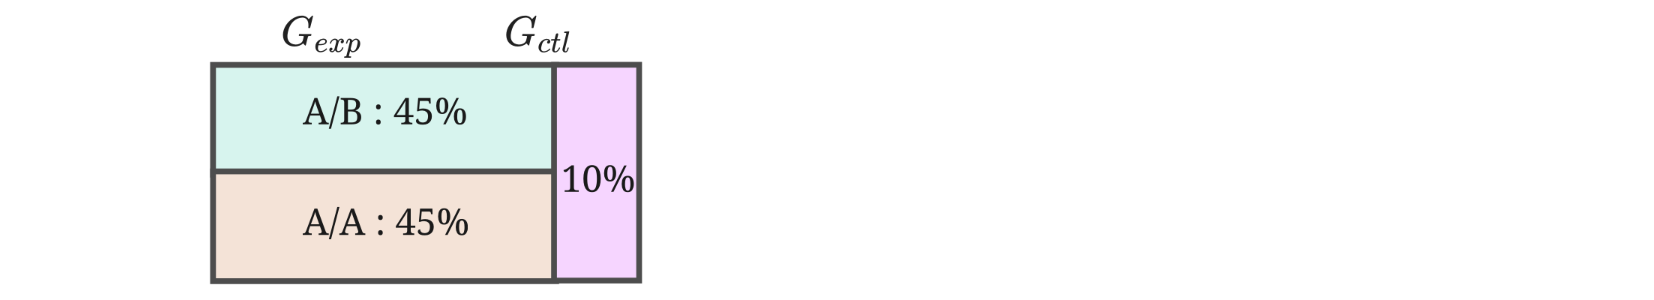

Let's consider RPU (revenue per user) to be the main metric. We'll use *t*-test to compare ARPU between groups

$$\text{ARPU} = \frac{\sum\limits_{i=1}^{n} \text{revenue}_i}{n}$$

where:
- $\text{revenue}_i$ - revenue of user $i$,
$\text{revenue}_i = \sum\limits_{j=1}^{m} \text{purchase}_j$
- $n$ - number of users, $m$ - number of a user's purchases

### Let's answer the question by calculating power for the A/B tests with the predefined effect (5%) and corresponding power for the GC/GT

In [2]:
iter = 1000
p_values_ab = np.zeros(iter)
p_values_gc = np.zeros(iter)
for i in range(iter):
    # Simulate the data
    n = 10000  # Number of users
    user_id = np.arange(n)  # User IDs
    revenue = np.random.normal(1000, 200, n) + np.random.lognormal(6, 1, n)  # Revenue
    GC = np.where(np.random.randint(0, 10, n) == 1, 1, 0)  # Global Control column (10%)
    expid = ['exp_' + str(i % 2 + 1) for i in user_id]  # Experiment ID: exp_1 - A/B, exp_2 - A/A
    variation = np.random.randint(0, 2, n)  # Variation column

    # Create a DataFrame
    df = pd.DataFrame({
        'user_id': user_id,
        'revenue': revenue,
        'GC': GC,
        'expid': expid,
        'variation': variation
    })

    # Simulate the uplift for A/B experiments
    uplift = np.where((df.expid == 'exp_1') & (df.variation == 1) & (df.GC == 0), 0.05, 0)
    df.revenue = df.revenue * (1 + uplift)

    # t-test for exp_1 (A/B, i.e. statsig experiments)
    exp_1_0 = df[(df.expid == 'exp_1') & (df.variation == 0)].revenue
    exp_1_1 = df[(df.expid == 'exp_1') & (df.variation == 1)].revenue
    p_values_ab[i] = ttest_ind(exp_1_0, exp_1_1, equal_var=False).pvalue

    # t-test global control vs global experiment
    gc = df[df.GC == 1].revenue
    ge = df[df.GC == 0].revenue
    p_values_gc[i] = ttest_ind(gc, ge, equal_var=False).pvalue

# print power
print(f'Power for A/B test that would get into production: {np.mean(p_values_ab < 0.05):.2f}')
print(f'Power for global control vs global experiment test: {np.mean(p_values_gc < 0.05):.2f}')

Power for A/B test that would get into production: 0.80
Power for global control vs global experiment test: 0.14


### Summary

As we can see from the results the power for the global control vs global experiment tests is much smaller than the power for the A/B tests (on the same data). This is because the effect is washed out by A/A tests and unequal sample sizes.
The power is not enough to detect the difference between the GC and GE even though the A/B tests give us 5% as relative effect.